In [1]:
import os
import datetime
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from hamsci_psws import geopack
%matplotlib inline

Re = 6371 # Radius of the Earth in km

In [2]:
mpl.rcParams['font.size']      = 12
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = np.array([15, 8])
mpl.rcParams['axes.xmargin']   = 0

## Define Station Locations

In [3]:
tx = {}
tx['st_id'] = 'WWV'
tx['lat']   =  40.68
tx['lon']   = -105.04

In [4]:
grapes = []

g = {}
g['st_id'] = 'kd2uhn'
g['lat']   =  40.6332
g['lon']   = -74.98881
g['color'] = 'purple'
grapes.append(g)

g = {}
g['st_id'] = 'n2rkl'
g['lat']   =  43.16319
g['lon']   = -76.12535
g['color'] = 'green'
grapes.append(g)

g = {}
g['st_id'] = 'n8obj'
g['lat']   =  41.321963
g['lon']   = -81.504739
g['color'] = 'cyan'
grapes.append(g)

grapes = pd.DataFrame(grapes)
grapes = grapes.set_index('st_id')
grapes

,lat,lon,color
st_id,,,
kd2uhn,40.633200,-74.988810,purple
n2rkl,43.163190,-76.125350,green
n8obj,41.321963,-81.504739,cyan


## Calculate midpoints between Transmitter and Receivers

In [5]:
grapes

grapes_new = []
for rinx, row in grapes.iterrows():
    # print(rinx)
    lat = row['lat']
    lon = row['lon']
    
    azm = geopack.greatCircleAzm(tx['lat'],tx['lon'],lat,lon)
    rng = geopack.greatCircleDist(tx['lat'],tx['lon'],lat,lon)*Re
    res = geopack.greatCircleMove(tx['lat'],tx['lon'],rng/2.,azm,alt=0,Re=Re)
    
    row['mid_lat'] = res[0][0]
    row['mid_lon'] = res[1][0]
    
    grapes_new.append(row)
    
grapes = pd.DataFrame(grapes_new)
grapes

,lat,lon,color,mid_lat,mid_lon
kd2uhn,40.633200,-74.988810,purple,41.644169,-90.009011
n2rkl,43.163190,-76.125350,green,42.839187,-90.870155
n8obj,41.321963,-81.504739,cyan,41.604411,-93.330499


## Load Eclipse Data

## Plot on a Map

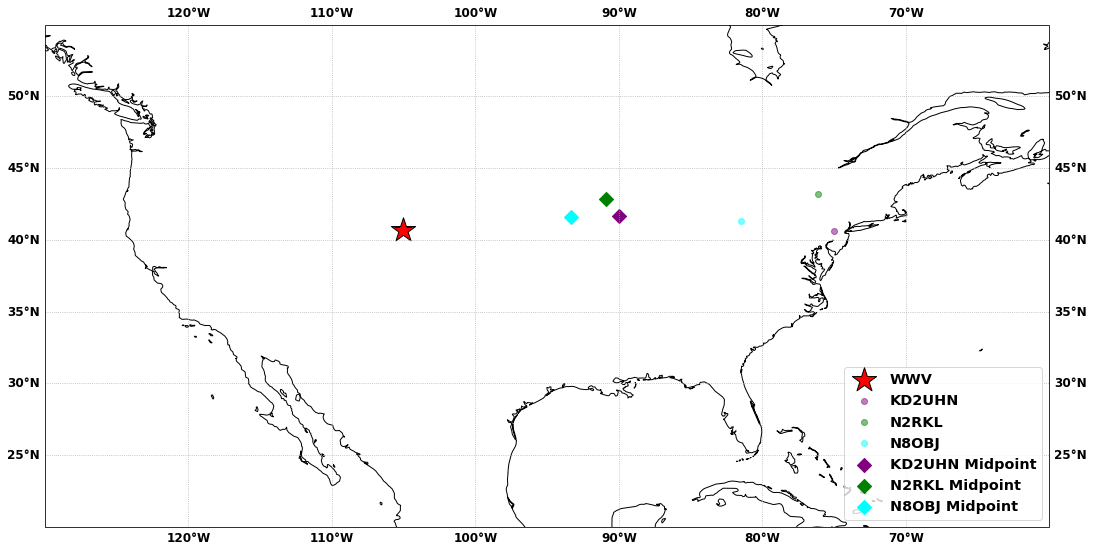

In [6]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,14))
ax  = fig.add_subplot(1,1,1,projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)

# for ecl_year,ecl_dict in eclipses.items():
#     ecl      = ecl_dict['ecl_data']
#     obsc_min = ecl_dict.get('obsc_min',0)
#     alpha     = ecl_dict.get('alpha',0.65)
#     cmap     = ecl_dict.get('cmap',mpl.cm.gray_r)
#     lats     = ecl.lats
#     lons     = ecl.lons
#     obsc_arr = ecl.get_obsc_arr(obsc_min=obsc_min)
#     pcoll    = ax.pcolormesh(lons,lats,obsc_arr,vmin=0,vmax=1,cmap=cmap,zorder=1,alpha=alpha)

alpha = 0.5
# Plot Transmitter
ax.scatter(tx['lon'],tx['lat'],marker='*',s=650,color='r',label=tx['st_id'],ec='black')

# Plot Ground Locations of Grapes
for rinx,row in grapes.iterrows():
    lat   = row['lat']
    lon   = row['lon']
    label = rinx.upper()
    color = row['color']
    ax.scatter([lon],[lat],label=label,c=[mpl.colors.to_rgb(color)],alpha=alpha)
    
# Plot Grape Midpoints
for rinx,row in grapes.iterrows():
    lat   = row['mid_lat']
    lon   = row['mid_lon']
    label = '{!s} Midpoint'.format(rinx.upper())
    color = row['color']

    ax.scatter([lon],[lat],label=label,c=[mpl.colors.to_rgb(color)],marker='D',s=100)

ax.legend(loc='lower right',fontsize='large')
    
# # World Limits
# ax.set_xlim(-180,180)
# ax.set_ylim(-90,90)

# US Limits
ax.set_xlim(-130,-60)
ax.set_ylim(20,55)

plt.show()